# Bike Rentals

This project looks at public bike rentals in Washington D.C, the data was scraped by Hadi Fanaee-T at the University of Porto. The data is available at http://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

In this project, we are trying to use machine learning to predict the number of bikes rented in a given hour, given factors like the time, the day, the weather etc. 

We will start with some simple linear regression, then move on to some decision trees and random forests!

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np

In [2]:
bike_rentals = pd.read_csv('./data/hour.csv')

## Exploratory Data Analysis

In [3]:
bike_rentals.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0,0,1,1


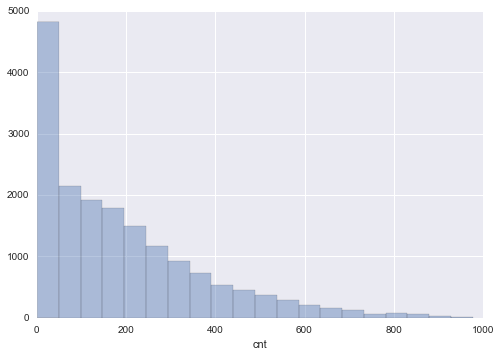

In [4]:
sns.distplot(bike_rentals['cnt'],bins=20,kde=False)
plt.show()

In [5]:
sorted_corrs = bike_rentals.corr().sort('cnt',ascending=False)
print(sorted_corrs['cnt'])

cnt           1.000000
registered    0.972151
casual        0.694564
temp          0.404772
atemp         0.400929
hr            0.394071
instant       0.278379
yr            0.250495
season        0.178056
mnth          0.120638
windspeed     0.093234
workingday    0.030284
weekday       0.026900
holiday      -0.030927
weathersit   -0.142426
hum          -0.322911
Name: cnt, dtype: float64


Quite a lot of variables are highly correlated with the cnt variable. We have to ignore 'registered' and 'casual' of course, since they are describing the number of registered users and casual users who rented a bike in that hour, and 

registered + casual = cnt 

and that would be cheating! We will remove those columns later.

First lets create a feature in which we group our time into either morning, afternoon, evening or night.

In [6]:
def assign_label(hour):
    if hour >= 6 and hour < 12: # morning
        return 1
    elif hour >= 12 and hour < 18: # afternoon
        return 2
    elif hour >= 18 and hour < 24: # evening
        return 3
    elif hour >= 0 and hour < 6: # night
        return 4
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(assign_label)

## A Suitable Error Metric and Linear Regression

Since we are dealing with continuous numerical data, the most suitable error metric would be mean-squared error (MSE).

In [7]:
# Split data into 80% training & 20% test data
from sklearn.cross_validation import train_test_split

train_columns = bike_rentals.columns.tolist()
train_columns.remove('cnt')
train_columns.remove('casual')
train_columns.remove('registered')
train_columns.remove('dteday')

X = bike_rentals[train_columns]
y = bike_rentals['cnt']
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.2, random_state=0)

In [8]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
predictions = lr.predict(X_test)

In [10]:
from sklearn import metrics

mse = metrics.mean_squared_error(y_test, predictions)

print(mse)

17401.3935204


The error is very high, we can see from the histogram above that some values of 'cnt' are very high. These outliers are giving us a large error because MSE is very unforgiving of outliers.

# Decision Tree Regression

In [11]:
from sklearn.tree import DecisionTreeRegressor

dtr = DecisionTreeRegressor(min_samples_leaf=10,max_depth=21)

dtr.fit(X_train,y_train)

DecisionTreeRegressor(criterion='mse', max_depth=21, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

In [12]:
predictions = dtr.predict(X_test)

In [13]:
dtr_mse = metrics.mean_squared_error(y_test, predictions)

print(dtr_mse)

2617.90698695


The error from a single decision tree is much smaller than simple linear regression. This is due to the fact that the decision tree can learn non-linear relationships between the input variables and the target variable.

In [14]:
dtr_mse = metrics.mean_squared_error(y_train, dtr.predict(X_train))

print(dtr_mse)

1644.0046294


As expected the mse from the training set is quite a bit smaller than the test set. This is becase a decision tree can be prone to overfitting, let's try an ensemble method and train a random forest.

# Random Forest

In [15]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators = 100, min_samples_leaf=5)

rfr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=5,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [16]:
predictions = rfr.predict(X_test)

In [17]:
rfr_mse = metrics.mean_squared_error(y_test,predictions)

print(rfr_mse)

1860.62790302


The random forest has given us a lower MSE on the test set because they are a good technique to avoid overfitting. By removing some of the sources of overgitting, we are picking up the actual signal in the data rather than learning the noise.